# Table of Contents
 <p><div class="lev1"><a href="#Vertical-profiles"><span class="toc-item-num">1&nbsp;&nbsp;</span>Vertical profiles</a></div><div class="lev2"><a href="#EOF-decomposition"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>EOF decomposition</a></div><div class="lev3"><a href="#With-all-data"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>With all data</a></div><div class="lev3"><a href="#In-the-99.9th-percentile-percentile-bin"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>In the 99.9th percentile percentile bin</a></div><div class="lev3"><a href="#Manually"><span class="toc-item-num">1.1.3&nbsp;&nbsp;</span>Manually</a></div>

In [1]:
%load_ext autoreload
%matplotlib inline

In [2]:
%autoreload 2

print("-- loading modules")
print()

import numpy as np
import numpy.ma as ma
import dask.array as da
import matplotlib
# matplotlib.use("PDF")
import matplotlib.pyplot as plt
import datetime as dt
import time
import sys,os,glob
from mpl_toolkits.basemap import Basemap
from matplotlib.colors import LogNorm
from statsmodels.multivariate.pca import PCA

## Add own library to path
workdir = os.getcwd()
thismodule = sys.modules[__name__]
moduledir = os.path.join(os.path.dirname(workdir),'functions')
sys.path.insert(0,moduledir)
print("Own modules available:", [os.path.splitext(os.path.basename(x))[0]
                                 for x in glob.glob(os.path.join(moduledir,'*.py'))])

## Load own libraries
from environmentAndDirectories import *
from importingData import *
from scalingApproximations import *
from slicingAndSubsetting import *
from thermoConstants import L_v,R_v
from plotMaps import *
from plot1DInvLog import *
from plot2D import *
from statisticalDistributions import *
from outputResults import *

## Graphical parameters
plt.style.use(os.path.join(matplotlib.get_configdir(),'stylelib/presentation.mplstyle'))

-- loading modules

Own modules available: ['CAMsettings', 'daskOptions', 'environmentAndDirectories', 'importingData', 'outputResults', 'physicalConstants', 'plot1DInvLog', 'plot2D', 'plotMaps', 'scalingApproximations', 'slicingAndSubsetting', 'statisticalDistributions', 'thermoConstants', 'thermoFunctions']


In [3]:
print()
print("-- define global variables")
print()

print("- choosing options:")
compset = 'FSPCAMm_AMIP'
experiment = 'piControl'
member = 'r1i1p1'
subset = 'tropics'
time_stride = '1d'
resolution = '1dx'
daskarray = False
tracktime = True
dates = ('185005010100','185005020000')

for v in ['compset','experiment','member','subset','time_stride','resolution',\
          'daskarray','dates']:
    print("%s:"%v,getattr(thismodule,v))

# Figure output directory
figdir = os.path.join(os.path.dirname(workdir),'figures','omega500tsps',compset,experiment,member,subset,\
                      time_stride,resolution)
os.makedirs(figdir,exist_ok=True)

# Results output directory
resultdir = os.path.join(os.path.dirname(workdir),'results','omega500tsps',compset,experiment,member,subset,\
                      time_stride,resolution)
os.makedirs(resultdir,exist_ok=True)

print()


-- define global variables

- choosing options:
compset: FSPCAMm_AMIP
experiment: piControl
member: r1i1p1
subset: tropics
time_stride: 1d
resolution: 1dx
daskarray: False
dates: ('185005010100', '185005020000')



In [4]:
if tracktime:
    t0 = time.time()

In [5]:
%%time
print("-- load environment and variables")
print()

historyFilesSettings = getCAMHistoryFilesSettings()
handle = 'h0'
inputdir, inputdir_processed_day, inputdir_processed_1hr, inputdir_results, inputdir_fx = \
    getInputDirectories(compset,experiment)

omega_id = 'OMEGA'
pr_id = 'PRECT'
ts_id = 'TS'
ta_id = 'T'
relhum_id = 'RELHUM'
ps_id = 'PS'

omega,pr,ts,ta,relhum,ps = getValues([omega_id,pr_id,ts_id,ta_id,relhum_id,ps_id],
                                  compset,subset,experiment,time_stride,resolution,daskarray=daskarray,dates=dates,handle=handle)
pr *= rho_l    # convert from m/s to kg/m2/s

-- load environment and variables

Importing OMEGA, PRECT, TS, T, RELHUM, PS from 24 history files between 1850-05-01-03600 and 1850-05-02-00000
CPU times: user 492 ms, sys: 326 ms, total: 818 ms
Wall time: 1.58 s


In [6]:
print("- compute pressure levels and saturation specific humidity")

input_lev_file = os.path.join(inputdir_fx,'lev_fx_CESM111-SPCAM20_allExperiments_r0i0p0.nc')
computeP = getPressureCoordinateFunction(input_lev_file)
pres = computeP(ps)
qvstar = saturationSpecificHumidity(pres=pres,temp=ta)

cn = getArrayType(pres)

- compute pressure levels and saturation specific humidity


# Vertical profiles

In [7]:
n_pts = pr.size
Q_IL = getInvLogRanks(n_pts,n_pts_per_bin=1,fill_last_decade=True)
i_Q = indexOfRank(99.9,Q_IL)
iQ_slice = slice(i_Q-5,i_Q+5)
ranks, centers, bins = computePercentilesAndBinsFromRanks(pr.flatten(),Q_IL)
iQ_min = 8
iQ_max = min(len(Q_IL),41)
# iQ_max = min(len(Q_IL),iQ_slice.stop)

# Define reference percentiles and compute percentiles
targetranks = Q_IL[iQ_min:iQ_max]
ranks_ref = Q_IL[:iQ_max]

In [8]:
ranks, centers, bins = computePercentilesAndBinsFromRanks(pr.flatten(),ranks_ref)
percentiles = adjustRanks(centers,ranks,ranks_ref)

rank_locations= {}
for rank in ranks_ref:
    rank_id  = "%2.4f"%rank
    print(rank_id,end=' ')
    rank_locations[rank_id] = getRankLocations(rank,pr,ranks,bins,rank_locations)
print()

0.0000 20.5672 36.9043 49.8813 60.1893 68.3772 74.8811 80.0474 84.1511 87.4107 90.0000 92.0567 93.6904 94.9881 96.0189 96.8377 97.4881 98.0047 98.4151 98.7411 99.0000 99.2057 99.3690 99.4988 99.6019 99.6838 99.7488 99.8005 99.8415 99.8741 99.9000 99.9206 99.9369 99.9499 99.9602 99.9684 99.9749 99.9800 99.9842 99.9874 99.9900 


In [9]:
print("Extract vertical profiles in Q-slice")

# iQ_slice_profiles = slice(i_Q,i_Q+1)
iQ_slice_profiles = slice(i_Q-5,i_Q+6)
iQ_ref = range(100)[iQ_slice_profiles]


varnames_for_profiles = ('omega','ta','pres')

ranks_tune = ["%2.4f"%(ranks_ref[iQ-1]) for iQ in iQ_ref]
# Initialize list for each variable
for varname in varnames_for_profiles:
    setattr(thismodule,"%s_ref_list"%varname,[])
# fill list with sample variables at each percentile
for rank in ranks_tune:
    stencil_Q = rank_locations[rank]
    for varname in varnames_for_profiles:
        var = getattr(thismodule,varname)
        var_list = getattr(thismodule,"%s_ref_list"%varname)
        var_list.append(sampleFlattened(var,stencil_Q))
# concat arrays from list
for varname in varnames_for_profiles:
    var_list = getattr(thismodule,"%s_ref_list"%varname)
    setattr(thismodule,"%s_ref"%varname,np.hstack(var_list))

qvstar_ref = saturationSpecificHumidity(ta_ref,pres_ref)

Extract vertical profiles in Q-slice


In [10]:
varnames_pc = ('omega','ta','pres','qvstar')

# compute mean profiles and anomalies
for varname in varnames_pc:
    var_array = getattr(thismodule,"%s_ref"%varname)
    var_ref_mean = np.mean(var_array,axis=1)
    var_ref_prime = var_array - np.vstack([var_ref_mean]*var_array.shape[1]).transpose()
    setattr(thismodule,"%s_ref_mean"%varname,var_ref_mean)
    setattr(thismodule,"%s_ref_prime"%varname,var_ref_prime)

In [11]:
print(omega_ref.shape,omega_ref_mean.shape,omega_ref_prime.shape)

(30, 25) (30,) (30, 25)


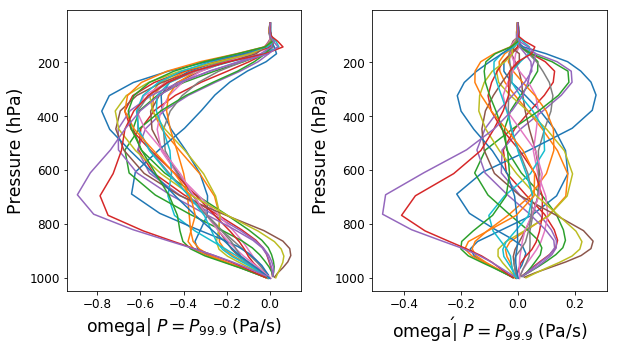

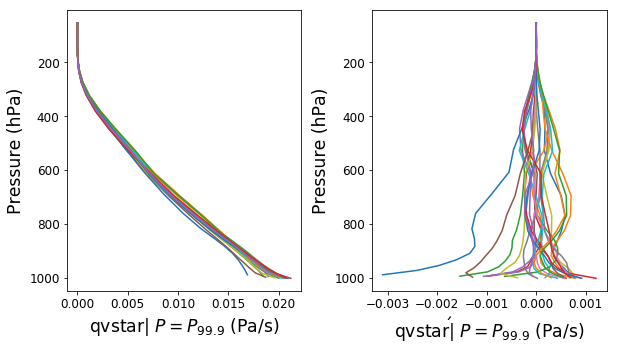

In [12]:

for varname in ('omega','qvstar'):

    var_ref = getattr(thismodule,"%s_ref"%varname)
    var_ref_prime = getattr(thismodule,"%s_ref_prime"%varname)
    
    
    fig, axs = plt.subplots(ncols=2,nrows=1,figsize=(10,5))

#     for i in range(var_ref.shape[1])[:12]:
    for i in range(var_ref.shape[1]):
        axs[0].plot(var_ref[5:,i],pres_ref[5:,i]/100)
        axs[1].plot(var_ref_prime[5:,i],pres_ref[5:,i]/100)

    for ax in axs:
        ax.invert_yaxis()
        ax.set_ylabel('Pressure (hPa)',fontsize='xx-large')

    axs[0].set_xlabel(r'%s$ |\,\, P=P_{99.9}$ (Pa/s)'%varname,fontsize='xx-large')
    axs[1].set_xlabel(r'%s$\' |\,\, P=P_{99.9}$ (Pa/s)'%varname,fontsize='xx-large')

## EOF decomposition

### With all data

In [13]:
L_v/R_v/300**2

0.054423734527765735

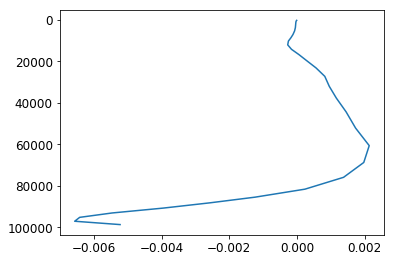

In [14]:
# Domain mean vertical velocity
omega_mean = np.mean(omega,axis=(0,2,3))
qvstar_mean = np.mean(qvstar,axis=(0,2,3))
pres_mean = np.mean(pres,axis=(0,2,3))
fig,ax = plt.subplots()
plt.plot(omega_mean,pres_mean)
ax.invert_yaxis()

In [15]:
levdim=1
nlev = pres.shape[levdim]
pr_for_pca = pr.flatten()
omega_for_pca = np.moveaxis(omega,levdim,-1).reshape((-1,nlev))
omega_for_pca = omega_for_pca - np.vstack([omega_mean]*omega_for_pca.shape[0])
qvstar_for_pca = np.moveaxis(qvstar,levdim,-1).reshape((-1,nlev))
qvstar_for_pca = qvstar_for_pca - np.vstack([qvstar_mean]*qvstar_for_pca.shape[0])
print(pr_for_pca.shape,omega_for_pca.shape,qvstar_for_pca.shape)
# x = np.concatenate([pr_for_pca.reshape((-1,1)),
#                     omega_for_pca,
#                     qvstar_for_pca],axis=1)
x = np.concatenate([omega_for_pca,
                    qvstar_for_pca],axis=1)
print("data shape: ",x.shape)

(4608,) (4608, 30) (4608, 30)
data shape:  (4608, 60)


In [16]:
# weights_for_pcs = np.vstack([pr.flatten()]*nlev)
# weights_for_pcs = pr.flatten()
# stencil = weights_for_pcs>0
# x = omega_for_pca[np.vstack([stencil]*nlev).transpose()].reshape((-1,nlev))
# w = weights_for_pcs[stencil]
# print(omega_for_pca.shape,x.shape,weights_for_pcs.shape)

# pc_omega = PCA(x,standardize=False,demean=True,weights=w)
pc_omega = PCA(omega_for_pca,standardize=False,demean=False)

In [17]:
pc_omega.eigenvecs[0]

array([ -1.86218106e-05,   2.97810077e-06,   3.21910027e-05,
         7.71841496e-05,   3.10268839e-04,  -1.18801323e-04,
         8.63099910e-05,  -1.39586715e-04,   7.40102957e-04,
        -5.31903839e-04,   4.85122056e-04,  -5.86899940e-04,
         6.26491515e-04,   6.84233433e-05,  -1.11419375e-03,
        -2.15431093e-03,   1.17487715e-03,   1.35432363e-03,
         3.45533966e-03,   8.75277548e-04,   1.75533152e-03,
         3.68640274e-03,   6.58205010e-03,   2.36336037e-03,
         2.40024518e-02,   4.98253989e-02,   1.55816208e-01,
        -5.68619331e-02,  -5.93527822e-01,  -7.85534679e-01])

In [18]:
a = np.linspace(1,10,10).reshape(5,2); print(a); print(a[:,0])
m = (np.random.random(5)>0.5); print(m)
# a[np.reshape([[m]]*2,(2,-1)).transpose()].reshape((-1,2))[:,0]
m2D = np.vstack([m.ravel()]*2).transpose()
print(m2D)
a[m2D].reshape((-1,2))

[[  1.   2.]
 [  3.   4.]
 [  5.   6.]
 [  7.   8.]
 [  9.  10.]]
[ 1.  3.  5.  7.  9.]
[ True  True  True False  True]
[[ True  True]
 [ True  True]
 [ True  True]
 [False False]
 [ True  True]]


array([[  1.,   2.],
       [  3.,   4.],
       [  5.,   6.],
       [  9.,  10.]])

### In the 99.9th percentile percentile bin

In [19]:
pc_omega_ref = PCA(omega_ref_prime.transpose(),standardize=False,demean=False)
pc_qvstar_ref = PCA(qvstar_ref_prime.transpose(),standardize=False,demean=False)

In [20]:
pc_omega_ref

Principal Component Analysis(nobs: 25, nvar: 30, transformation: None, normalization: True, number of components: 25, SVD, id: 0x1a1e025908)

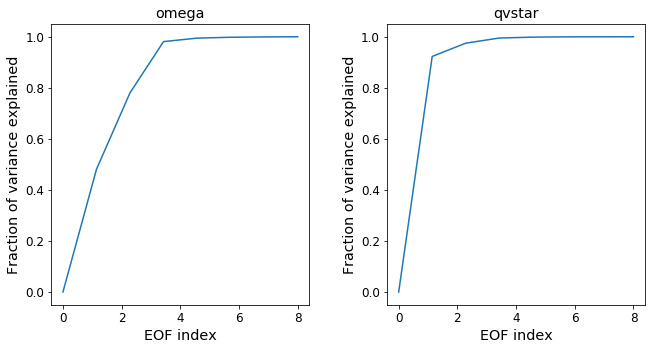

In [21]:
vars_to_plot = ('omega','qvstar')
n = len(vars_to_plot)

fig, ax = plt.subplots(ncols=n,nrows=1,figsize=(5*n+1*(n-1),5))

for i in range(n):
    varname = vars_to_plot[i]
    
    pc_ref = getattr(thismodule,"pc_%s_ref"%varname)
    
    varexp_cum = np.hstack([[0],np.cumsum(pc_ref.eigenvals)])
    varexp_sum = np.max(varexp_cum)
    
    nmodes = 8
    x = np.linspace(0,nmodes,nmodes)
    ax[i].plot(x,varexp_cum[:nmodes]/varexp_sum)
    ax[i].set_title(varname)
    ax[i].set_xlabel("EOF index")
    ax[i].set_ylabel("Fraction of variance explained")
plt.show()

We need 3 eigenvectors to properly quantify the variability in $\omega$, while 1 is enough for $q_v^\star$.

### Manually

In [37]:
D,N = omega_ref_prime.shape

In [57]:
def getEOFmodes(A,threshold=0.95):
    U,S,Vh = np.linalg.svd(A)
    n_max = np.argmax(np.cumsum((S**2)/(S**2).sum())>threshold)
    modes = []
    for i in range(n_max):
        modes.append(S[i] * Vh[i,:])
    return np.array(modes)

In [78]:
omega_modes = getEOFmodes(omega_ref_prime.T,0.95)
qvstar_modes = getEOFmodes(qvstar_ref_prime.T,0.95)

(-0.005, 0.002)

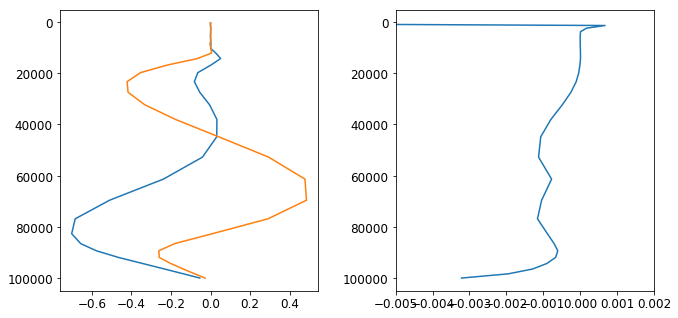

In [79]:
fig,ax = plt.subplots(ncols=2,figsize=(11,5))
for i in range(len(omega_modes)):
    ax[0].plot(omega_modes[i],pres_ref_mean)
for i in range(len(qvstar_modes)):
    ax[1].plot(qvstar_modes[i],pres_ref_mean)
ax[0].invert_yaxis()
ax[1].invert_yaxis()
ax[1].set_xlim((-0.005,0.002))